# Starting from scratch, build up everything

- Features, testing framework, etc.

Learnings
- objective function
- ensemble across different folds for less variance

- val set improvement == leaderboard improvement (but need to retrain for each)

In [57]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor, DMatrix
import shap
import lightgbm as lgb
import time
import functools
shap.initjs()
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date']).sort_values(by='date')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date']).sort_values(by='date')
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
weight = pd.read_csv(DIRECTORY + 'test_weights.csv')

In [59]:
train = train.dropna(axis=0).sort_values(by='date').reset_index(drop=True)
test = test.sort_values(by='date').reset_index(drop=True)

In [60]:
# Add some naive features
from statsmodels.tsa.deterministic import CalendarFourier

def date(df):
    df = df.reset_index(drop=True)
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    df['day_of_week'] = df['date'].dt.day_of_week
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    cal_fourier = CalendarFourier("YE", 1)
    cal_fourier = cal_fourier.in_sample(df['date']).reset_index(drop=True)
    assert(len(cal_fourier) == len(df))
    df = pd.concat([df, cal_fourier], axis=1)
    return df

def rolling_sales(df, day):
    for lag in [day]:
        df[f'lag{lag}'] = df.groupby('unique_id')['sales'].shift(lag)
    for rolling in [2, 7, 90, 365]:
        df[f'rolling{rolling}_lag14'] = df.groupby('unique_id')[f'lag{day}'].rolling(rolling, min_periods=min(rolling//2, 10)).mean()\
                                            .reset_index(level=0, drop=True)
    return df

def zscores(df):
    # price, total orders, discounts
    discount_cols = [col for col in df.columns if '_discount' in col]
    df['discount'] = df[discount_cols].max(axis=1)

    cols = ['sell_price_main', 'total_orders', 'discount']
    for col in cols:
        df[f'{col}_zs'] = (df[col] - df.groupby('unique_id')[col].transform('mean')) / df.groupby('unique_id')[col].transform('std').replace(0, 1)
        df[f'{col}_detrended'] = df[f'{col}_zs'] - df.groupby(['date', 'warehouse'])[f'{col}_zs'].transform('mean')
    return df

def noise(df):
    df['normal_noise'] = np.random.normal(loc=0, scale=1, size=len(df))
    df['uniform_noise'] = np.random.uniform(low=0, high=1, size=len(df))
    return df

def categorical(df):
    df['common_name'] = df['name'].str.split('_').str[0]
    df['common_name_warehouse'] = df['common_name'].astype(str) + '_' + df['warehouse'].astype(str) 
    return df

def delete_useless(df):
    useless_categorical = np.setdiff1d([col for col in df.columns if 'category_name' in col], ['L3_category_name_en'])
    useless_discount = np.setdiff1d([col for col in df.columns if '_discount' in col], ['type_0_discount'])
    other_useless = ['holiday', 'shops_closed', 'year', 'product_unique_id']

    useless = list(useless_categorical) + list(useless_discount) + other_useless
    df = df.drop(columns=useless, errors='ignore')
    return df

In [61]:
all_data = pd.concat([train, test], axis=0)

calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
all_data = all_data.merge(calendar[['date', 'holiday', 'shops_closed', 'warehouse']], on=['date', 'warehouse'])
all_data = all_data.merge(inventory.drop(columns='warehouse'), on=['unique_id'])

In [48]:
all_data = date(all_data)
all_data = rolling_sales(all_data, 14)
all_data = zscores(all_data)
all_data = noise(all_data)
all_data = categorical(all_data)
all_data = delete_useless(all_data)

## Xgboost

In [49]:
cat_cols = list(all_data.select_dtypes('object').columns) + list(['unique_id'])
all_data[cat_cols] = all_data[cat_cols].astype('category')

In [50]:
train_start = pd.to_datetime('2022-01-01')
train_end = pd.to_datetime('2024-06-02')

train_split = all_data[(all_data['date'] >= train_start) & (all_data['date'] <= train_end)]
test_split = all_data[all_data['date'] > train_end]

In [51]:
xgb_params = {
    'n_estimators': 5000,
    'objective': 'reg:squarederror',
    'enable_categorical': True,
    'learning_rate': 0.1,
    'device': 'cuda',
    'min_child_weight': 1,
    'early_stopping_rounds': 20,
    'lambda': 0.8,
    'seed': 42
}

In [52]:
# Just do val set
rmse = True
drop_cols = ['date', 'sales', 'availability', 'name']
kf = RepeatedKFold(n_splits=3, n_repeats=1)

test_preds = []
oof_pred_df = pd.DataFrame(index=train_split.index, columns=['predictions', 'actual'])
model = None

for i, (train_idx, test_idx) in enumerate(kf.split(train_split)):
    X_train, X_test = train_split.iloc[train_idx].drop(columns=drop_cols), train_split.iloc[test_idx].drop(columns=drop_cols)
    y_train, y_test = train_split.iloc[train_idx]['sales'], train_split.iloc[test_idx]['sales']
    if rmse: y_train, y_test = np.sqrt(y_train), np.sqrt(y_test)
    
    final_X_test = test_split.drop(columns=drop_cols)

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=1000
    )

    fold_test_pred = xgb_model.predict(final_X_test)
    if rmse: fold_test_pred = fold_test_pred**2
    test_preds.append(fold_test_pred)

    oof_pred = xgb_model.predict(X_test)
    oof_pred_df.iloc[test_idx,0] = (oof_pred**2 if rmse else oof_pred)
    oof_pred_df.iloc[test_idx,1] = (y_test**2 if rmse else y_test)

[0]	validation_0-rmse:5.86451
[1000]	validation_0-rmse:1.32671
[2000]	validation_0-rmse:1.29605
[2895]	validation_0-rmse:1.28637
[0]	validation_0-rmse:5.89023
[1000]	validation_0-rmse:1.33843
[2000]	validation_0-rmse:1.30617
[3000]	validation_0-rmse:1.29401
[3263]	validation_0-rmse:1.29284
[0]	validation_0-rmse:5.90569
[1000]	validation_0-rmse:1.33233
[2000]	validation_0-rmse:1.30108
[3000]	validation_0-rmse:1.29065
[3208]	validation_0-rmse:1.28951


In [53]:
# Check oof prediction score
train_split_weights = train_split['unique_id'].map(weight.set_index('unique_id')['weight']).reset_index(drop=True)
train_split_weights.name = 'weight'
actually_predicted = pd.concat([oof_pred_df.reset_index(drop=True), train_split_weights], axis=1).dropna(axis=0)

mean_absolute_error(actually_predicted['predictions'], actually_predicted['actual'], sample_weight=actually_predicted['weight'])

14.047337618619467

In [54]:
np.mean(test_preds, axis=0)

array([22.496328, 29.277136, 83.57337 , ..., 16.568953, 64.46732 ,
       22.869888], dtype=float32)

In [55]:
OWN_OUTPUT_DIRECTORY = './own_outputs/'
res_df = pd.DataFrame({
    'id': test_split['unique_id'].astype(str) + '_' + test_split['date'].astype(str),
    'sales_hat': np.mean(test_preds, axis=0)
    })
res_df.to_csv(OWN_OUTPUT_DIRECTORY + 'sales_correct.csv', index=False)

In [99]:
for fold in range(3):
    fold_prediction = res_df.copy()
    fold_prediction['sales_hat'] = test_preds[fold]
    fold_prediction.to_csv(OWN_OUTPUT_DIRECTORY + f'with_holidays{fold}.csv', index=False)

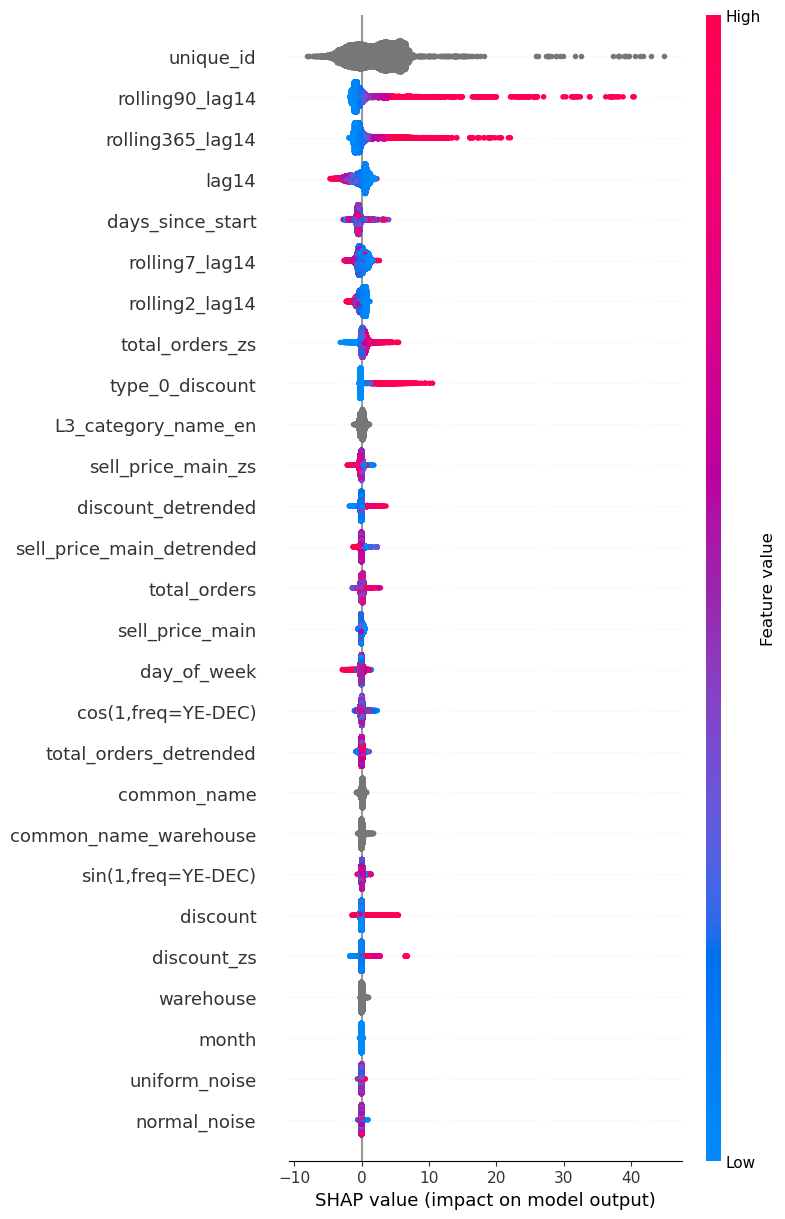

In [56]:
test_dm = DMatrix(test_split.drop(columns=drop_cols), enable_categorical=True)
shap_values = xgb_model.get_booster().predict(test_dm, pred_contribs=True)
shap.summary_plot(shap_values[:,:-1], test_split.drop(columns=drop_cols), max_display=40)

In [30]:
all_data['name'].nunique()

2653